# Sea ice regression

Q. Can we predict Arctic sea ice concentration from large-scale climate modes/phenomena (e.g., NOA, CO2, AO, Nino3.4)?



### Download data sources

Timeseries
* nao:  https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii.table
* nino: https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Data/nino34.long.anom.data
* ao:   https://www.esrl.noaa.gov/psd/data/correlation/ao.data
* co2:  ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt

Gridded Arctic sea ice concentration (SIC) data. Values range between 0 and 100, with land points represented by -1
* Full dataset (zip, 263MB): ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G10010/G10010_SIBT1850_v1.1.zip
* Sub-region (nc): https://github.com/scott-hosking/notebooks/blob/master/sea_ice_data/sic_subregion.nc?raw=true

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR, SVR
from sklearn import linear_model
from sklearn import preprocessing

# installation: http://xarray.pydata.org/en/stable/installing.html
import xarray as xr
import cartopy
import cartopy.crs as ccrs

In [2]:
def reshape_col_month(df, col_name):
    new = pd.DataFrame(columns=['Year', 'Month', col_name])
    yr_arr, mon_arr = [], []
    for yr in df['Year'].values: 
        yr_arr  = np.append( yr_arr, np.repeat(yr,12) )
        mon_arr = np.append( mon_arr, np.arange(1,13) )
    new['Year']   = yr_arr.astype(int)
    new['Month']  = mon_arr.astype(int)
    # new[col_name] = np.array(df.drop(columns='Year')).flatten()
    new[col_name] = np.array(df.drop(['Year'], axis=1)).flatten()
    return new

In [3]:
'''
Read Data
---------

'''

url = 'sea_ice_data/norm.nao.monthly.b5001.current.ascii.table'
nao = pd.read_csv(url, delim_whitespace=True, header=None)
nao.rename(columns = {0: 'Year'}, inplace=True)
nao = reshape_col_month(nao, 'NAO')
nao['Day'] = 15
dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in nao.iterrows() ]
nao['time'] = pd.DatetimeIndex(dt)
nao = nao.drop(columns=['Day'])


url = 'sea_ice_data/nino34.long.anom.data'
nino = pd.read_csv(url, skiprows=1, skipfooter=7, delim_whitespace=True, header=None)
nino.rename(columns = {0: 'Year'}, inplace=True)
nino = reshape_col_month(nino, 'NINO')
nino['Day'] = 15
dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in nino.iterrows() ]
nino['time'] = pd.DatetimeIndex(dt)
nino = nino.drop(columns=['Day'])


url = 'sea_ice_data/ao.data'
ao = pd.read_csv(url, skiprows=1, skipfooter=3, delim_whitespace=True, header=None)
ao.rename(columns = {0: 'Year'}, inplace=True)
ao = reshape_col_month(ao, 'AO')
ao['Day'] = 15
dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in ao.iterrows() ]
ao['time'] = pd.DatetimeIndex(dt)


url = 'sea_ice_data/co2_mm_mlo.txt'
co2 = pd.read_csv(url, skiprows=72, delim_whitespace=True, usecols=[0,1,3], names=['Year','Month','CO2'])
co2['Day'] = 15
dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in co2.iterrows() ]
co2['time'] = pd.DatetimeIndex(dt)

### merge time series
df = pd.merge(nino,nao)
df = pd.merge(df,ao)
df = pd.merge(df,co2)

df = df.drop(columns=['Day'], axis=0)

df.head()

/home/scott/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
/home/scott/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:34: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


,Year,Month,NINO,time,NAO,AO,CO2
0,1958,3,0.99,1958-03-15,-1.96,-2.522,315.71
1,1958,4,0.31,1958-04-15,0.37,-0.360,317.45
2,1958,5,0.32,1958-05-15,-0.24,-0.336,317.50
3,1958,6,0.30,1958-06-15,-1.38,-1.149,-99.99
4,1958,7,0.04,1958-07-15,-1.73,-0.684,315.86


# Full sea ice data (it's big)
You might prefer to skip a few cells to see how we read in and analyse the sub-region data (see: 'Regression at a single point')

In [4]:
'''
Sea ice data located here: ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G10010/G10010_SIBT1850_v1.1.zip

Here I used Xarray to load and process the data. 
The Xarray DataArray (da) is a container for Numpy arrays (da.values) and metadata. 

I also have a notebook here which might be useful: https://github.com/scott-hosking/notebooks/blob/master/xarray_examples.ipynb

'''

ds = xr.open_dataset('~/Large_Data/SeaIce/G10010_SIBT1850_v1.1/G10010_SIBT1850_v1.1.nc')
da = ds.seaice_conc
da = da.sel(time=slice('1979-01-01', None)) # take slice over the satellite era only (1979-present)

In [5]:
# Lets have a look at the data structure (contained in an Xarray DataArray)
da

<xarray.DataArray 'seaice_conc' (time: 420, latitude: 240, longitude: 1440)>
[145152000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 89.875 89.625 89.375 89.125 88.875 88.625 ...
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 ...
  * time       (time) datetime64[ns] 1979-01-15 1979-02-15 1979-03-15 ...
Attributes:
    short_name:     concentration
    long_name:      Sea_Ice_Concentration
    standard_name:  Sea_Ice_Concentration
    units:          Percent

Text(0.5,1,'Sea ice concentration for first time index')

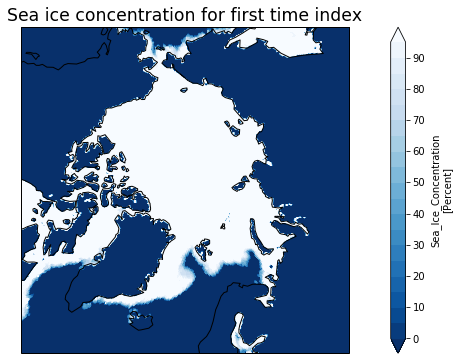

In [7]:
plt.figure(figsize=(15,6))
ax = plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
da.isel(time=0).plot.contourf('longitude', 'latitude', ax=ax, levels=range(0,100,5),
                              cmap='Blues_r', transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND)
ax.coastlines()
ax.set_title('Sea ice concentration for first time index', size='xx-large')

# Extract a small region

Text(0.5,1,'Zoomed in')

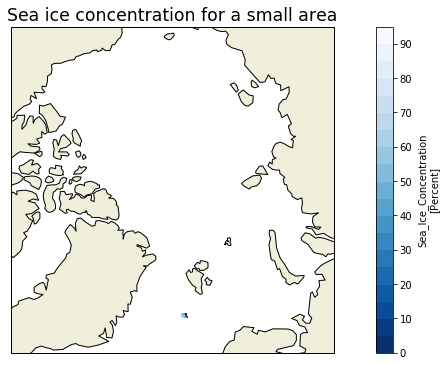

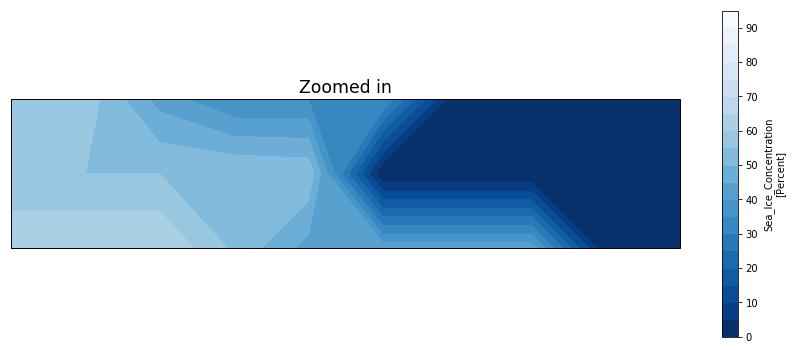

In [62]:
### Work on a small slice of data (using index select, isel)
da1 = da.isel(latitude=slice(60,63),longitude=slice(20,30))

plt.figure(figsize=(15,6))
ax = plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 70, 90], ccrs.PlateCarree())
da1.isel(time=0).plot.contourf('longitude', 'latitude', ax=ax, levels=range(0,100,5),
                              cmap='Blues_r', transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND)
ax.coastlines()
ax.set_title('Sea ice concentration for a small area', size='xx-large')


plt.figure(figsize=(15,6))
ax = plt.subplot(projection=ccrs.PlateCarree())
da1.isel(time=0).plot.contourf('longitude', 'latitude', ax=ax, levels=range(0,100,5),
                              cmap='Blues_r', transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND)
ax.coastlines()
ax.set_title('Zoomed in', size='xx-large')

In [ ]:
### Save data to file
da1.to_netcdf('sea_ice_data/sic_subregion.nc')

In [50]:
times = da1.time

# Regression at a single point

In [69]:
da1 = xr.open_dataarray('sea_ice_data/sic_subregion.nc')

nlons = da1.longitude.shape[0]
nlats = da1.latitude.shape[0]
    
j,i = 0,0 # <-- we could loop over these indices later.

### extract one grid-point from DataArray and convert to pandas dataframe
sic = da1.isel(latitude=j, longitude=i).to_dataframe().reset_index()

### merge data with large-scale climate models
df_a = pd.merge(df,sic)

df_a = df_a.drop(axis=1,labels='time')

df_a.head()

,Year,Month,NINO,NAO,AO,CO2,seaice_conc,latitude,longitude
0,1979,1,0.05,-1.38,-2.233,336.14,58.0,74.875,5.125
1,1979,2,0.09,-0.67,-0.697,336.69,51.0,74.875,5.125
2,1979,3,0.13,0.78,-0.814,338.27,0.0,74.875,5.125
3,1979,4,0.17,-1.71,-1.157,338.95,0.0,74.875,5.125
4,1979,5,-0.09,-1.03,-0.250,339.21,0.0,74.875,5.125


In [57]:
X   = df_a[['Month', 'NAO', 'NINO', 'AO', 'CO2']].values
Y   = df_a['seaice_conc'].values
yrs = df_a['Year'].values

### Split data into training and testing datasets
train_ind, test_ind = np.where(yrs >= 2010)[0], np.where(yrs < 2010)[0]
X_train, X_test, Y_train, Y_test = X[train_ind,:], X[test_ind,:], \
                                    Y[train_ind], Y[test_ind]

# now what... :-)